In [1]:
# load packages
import numpy as np 
import scipy 
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
import mne
from mne.viz import plot_topomap
from mne.viz import set_3d_title, set_3d_view
sns.set_theme() # set the plotting atmosphere

### Import all files that will be sorted and exported from + into another .mat file

In [2]:
# Main Directory of processed file from MatLab
#MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir
MainDir = 'C:\\plimon\\LTP_analysis\\eegMatFiles\\AllMAT' # set dir
os.chdir(MainDir) # change old dir, to this dir
dataFileNames = os.listdir(MainDir) # list files in dir
print(f'Total Files Avilable: {len(dataFileNames)}')
##############################################
FileN = dataFileNames[0]# choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Total Files Avilable: 1
Current WD: C:\plimon\LTP_analysis\eegMatFiles\AllMAT\AllSubj_MatFiles_C1_20240412_110418.pkl
Does File #1 Exist? True


In [3]:
NumBins = 6
NumHarms = 4

#### Print Keys in original data

In [4]:
loadData = pkl.load(open(file_path1, 'rb'))
print(loadData.keys())
print(len(loadData['RawData'].keys()))

dict_keys(['RawData', 'SubjNames'])
50


In [5]:
def GetDims(DictIn):
    """This script gets the dims of data 
    for later indexing"""
    iter = int(len(DictIn.keys())-1)
    NumDims = np.zeros((int(iter),3))
    for Sind in range(iter):
        NumDims[Sind,:] = DictIn[Sind].shape
    return NumDims

In [6]:
Dims = GetDims(loadData['RawData']) # shape of all subjs data

print(f'Variability of Rows: {np.unique(Dims[:,0],return_counts = True)}')
print(f'Variability of Chans: {np.unique(Dims[:,1])}')
print(f'Variability of Trials: {np.unique(Dims[:,2], return_counts = True)}')

NumChans = ((np.unique(Dims[:,1])))[0]

Variability of Rows: (array([112., 126.]), array([10, 39], dtype=int64))
Variability of Chans: [128.]
Variability of Trials: (array([78., 80.]), array([47,  2], dtype=int64))


In [7]:
s_iters = int(Dims.shape[0])

splitRowInd = []
splitCondInd = []

for sIn in range(s_iters):
    dataDimsIn= Dims[sIn,:] # info for indexing rows, cols and trials
    splitRowInd.append(int((dataDimsIn[0]/2))) # cutoff for splitting data along real-imag axis
    splitCondInd.append(int(dataDimsIn[2]/2)) # cutoff for splitting trials as pre and post  
splitRowInd = np.array(splitRowInd)
splitCondInd = np.array(splitCondInd)

### Select Channels of Interest to Visualize Later

In [47]:
elecLeftLateral=[51,52,60,58,59,64,65,68,69]
elecLeftMedial=[72,75,81,70,71,74]
elecRightMedial=[72,75,81,76,83,82]
elecMedial=[72,75,81,70,71,74,76,83,82]
elecRightLateral=[97,92,85,96,91,95,90,94,88]
extraChans = np.arange(50,100,1)
extra = [107,101,47,42,37,31,102,46,41,45,49,103,108,113,108,99]
AnalysisChans = [elecLeftLateral,elecLeftMedial,elecRightMedial,elecMedial,elecRightLateral,extraChans,extra]
ExportChans = np.unique(np.sort(np.concatenate(AnalysisChans))) # Combine array for chans of interest
VisChans  = ExportChans - 1
print(f'Channels to be visualized: {VisChans}')

Channels to be visualized: [ 30  36  40  41  44  45  46  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98 100 101 102 106 107 112]


#### Make Bool mask for MNE Topoplots

In [48]:
chanList = np.arange(0,Dims[0,1],1)
ocm = np.zeros_like((chanList))
ocm[VisChans] = True # set good chans to true

ocm_chans = ocm.astype(bool)
print(ocm_chans)

#### Combine Real and Imaginary Components of data

In [10]:
# maybe has to add a mask before hypot is computed
cleanData = {}
for sIn in range(s_iters):
    RawData = loadData['RawData'][sIn]
     # reshape data so 0 = real and 1 = imaginary values 
    reshapeData  = RawData.reshape((splitRowInd[sIn]),2,int(Dims[sIn,1]),int(Dims[sIn,2]))
    # replace bad chans with nan's
    reshapeData[reshapeData == 0] = np.nan
    # empty dataframe
    comboData = np.zeros((splitRowInd[sIn],int(Dims[sIn,1]),int(Dims[sIn,2])))
    unique_Iter = splitRowInd[sIn]
    for val in range(unique_Iter):
        comboData[val,:,:] = np.hypot(reshapeData[val,0,:,:],reshapeData[val,1,:,:])
    cleanData[sIn] = comboData

#### Get Data Per Bin and Store in Dict, Remove Prelude Bins

In [11]:
preBins = NumBins + 1 #(+1 bc prelude bin)
GoodBinData = {}

for sIn in range(s_iters):
    dIn = cleanData[sIn] # import 1 subjs data 
    rmvBinInd = np.array(np.arange(0,splitRowInd[sIn],preBins)) # set indices to remove 1st (oth bin) out of every 7th
    ind_arr = np.ones(splitRowInd[sIn]) # all rows good as default
    ind_arr[rmvBinInd] = False # id prelude bins
    GoodBinData[sIn] = dIn[ind_arr == 1,:,:] # save into dict 

## **Check Point #1** : Make sure 1F1 harmonic data is **NOT** included in analysis

In [12]:
HarmonicDataCo = 4 # should be 2f 4 f 6f and 8f data
HemiFieldDataCo = 2 # should exist for f1 and f2
idealHarmOrd = HarmonicDataCo*HemiFieldDataCo # 8

allHemiData = {}
for sIn in range(s_iters):
# if data along rows is not divisible, remove 1f1 data
    if (GoodBinData[sIn].shape[0] % idealHarmOrd) != 0:
        print(f'Data File # {sIn} contains 1F1 data, now removing ...')
        allHemiData[sIn] = GoodBinData[sIn][NumBins:,:,:] # remove the 1st 6 values of data 
    else:
        print(f'File # {sIn} was preserved')
        allHemiData[sIn] = GoodBinData[sIn]

Data File # 0 contains 1F1 data, now removing ...
Data File # 1 contains 1F1 data, now removing ...
Data File # 2 contains 1F1 data, now removing ...
Data File # 3 contains 1F1 data, now removing ...
Data File # 4 contains 1F1 data, now removing ...
Data File # 5 contains 1F1 data, now removing ...
Data File # 6 contains 1F1 data, now removing ...
Data File # 7 contains 1F1 data, now removing ...
Data File # 8 contains 1F1 data, now removing ...
Data File # 9 contains 1F1 data, now removing ...
Data File # 10 contains 1F1 data, now removing ...
Data File # 11 contains 1F1 data, now removing ...
Data File # 12 contains 1F1 data, now removing ...
Data File # 13 contains 1F1 data, now removing ...
Data File # 14 contains 1F1 data, now removing ...
Data File # 15 contains 1F1 data, now removing ...
Data File # 16 contains 1F1 data, now removing ...
Data File # 17 contains 1F1 data, now removing ...
Data File # 18 contains 1F1 data, now removing ...
Data File # 19 contains 1F1 data, now rem

#### F1 and F2 data are stacked on top of each other so here we split them :)

In [13]:
xF1HemiData = {} # data is : 2f1 4f1 6f1 8f1
xF2HemiData = {} # data is  2f2 4f2 6f2 8f2

for sIn in range(s_iters):
    HarmonicCutoff = int(allHemiData[sIn].shape[0] / 2)
    xF1HemiData[sIn] = np.array(allHemiData[sIn][:HarmonicCutoff,:,:]) # harmonics x channels x trials  = 4 x 128 x 78
    xF2HemiData[sIn] = np.array(allHemiData[sIn][HarmonicCutoff:,:,:]) # harmonics x channels x trials 

In [14]:
xF1HemiBins = {}
xF2HemiBins = {}
for sIn in range(s_iters):
    x1 = xF1HemiData[sIn]
    x2 = xF2HemiData[sIn]
    HarmonicEpochs = np.array(np.arange(0,x1.shape[0],NumBins)) # index to segment bins

    xF1HemiBins[sIn] = {}
    xF2HemiBins[sIn] = {}
    for xFX in range(HarmonicDataCo):
        xF1HemiBins[sIn][xFX] = x1[HarmonicEpochs[xFX]:HarmonicEpochs[xFX]+(NumBins),:,:]
        xF2HemiBins[sIn][xFX] = x2[HarmonicEpochs[xFX]:HarmonicEpochs[xFX]+(NumBins),:,:]
        #print(xF1HemiBins[sIn][xFX].shape)
    

### seperate data into pre and post 

In [25]:
def DataSort(dictIn, sIn):
    """This function takes 1 subjects data.
        Data contains 6 keys per bin.
        Returns: Pre, Post and Post-Pre, and 2*(Post-Pre)/(Pre+Post) """
    BinDiffArith_Out = {}
    BinBaseDiff_Out = {}
    BinPrePost_Out = {}
    fx = dictIn[sIn] # import data 

    for harmonic in range(NumHarms):

        fx_avg = np.zeros((NumBins,int(len(chanList)),2)) # bins x channel x pre/post
        fx_diff = np.zeros((NumBins,int(len(chanList))))
        fx_sum = np.zeros_like(fx_diff)
        fx_diffArith = np.zeros_like(fx_diff)

        nt = int((fx[harmonic].shape[2])/2)
        fx_temp = np.reshape(fx[harmonic], newshape = (NumBins,int(NumChans),2,nt))
        #get pre and post induction average
        for induCo in range(2):
            fx_avg[:,:,induCo] = np.nanmean(fx_temp[:,:,induCo,:], axis = 2) # 6 x 128 
        for bin in range(NumBins):
            fx_diff[bin,:] = fx_avg[bin,:,1] - fx_avg[bin,:,0] # post - pre
            fx_sum[bin,:] = fx_avg[bin,:,1] + fx_avg[bin,:,0] 
            fx_diffArith[bin,:] = 2*(((fx_diff[bin,:])/(fx_sum[bin,:])))

        BinDiffArith_Out[harmonic] = fx_diffArith
        BinBaseDiff_Out[harmonic] = fx_diff
        BinPrePost_Out[harmonic] = fx_avg

    return BinDiffArith_Out,BinBaseDiff_Out,BinPrePost_Out

In [26]:
bda_f1 = {}
bbd_f1 = {}
bpp_f1 = {}

for s in range(s_iters):
    #print(f'now sorting data file # {s}')
    bda_f1[s], bbd_f1[s], bpp_f1[s] = DataSort(xF1HemiBins, sIn = s)


C:\Users\plimon\AppData\Local\Temp\ipykernel_26280\48880120.py:21: RuntimeWarning: Mean of empty slice
  fx_avg[:,:,induCo] = np.nanmean(fx_temp[:,:,induCo,:], axis = 2) # 6 x 128


In [27]:
bda_f2 = {}
bbd_f2 = {}
bpp_f2 = {}

for s in range(s_iters):
    #print(f'now sorting data file # {s}')
    bda_f2[s], bbd_f2[s], bpp_f2[s] = DataSort(xF2HemiBins, sIn = s)

C:\Users\plimon\AppData\Local\Temp\ipykernel_26280\48880120.py:21: RuntimeWarning: Mean of empty slice
  fx_avg[:,:,induCo] = np.nanmean(fx_temp[:,:,induCo,:], axis = 2) # 6 x 128


(128,)


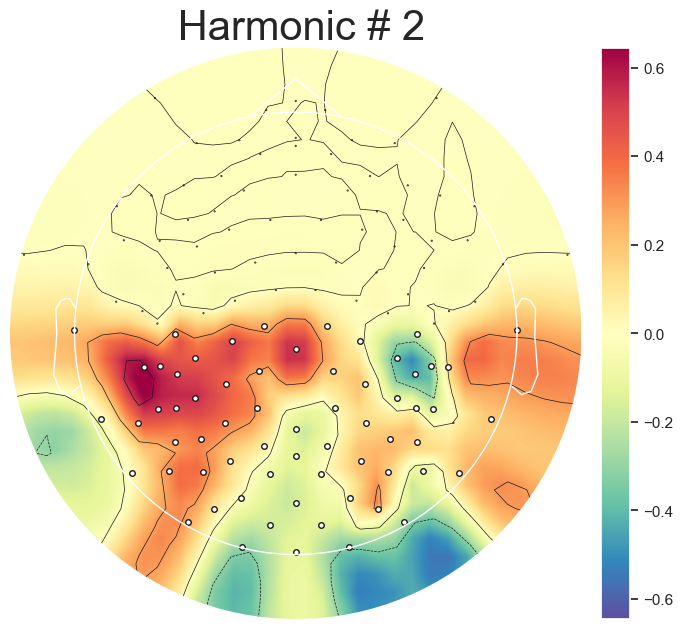

(128,)


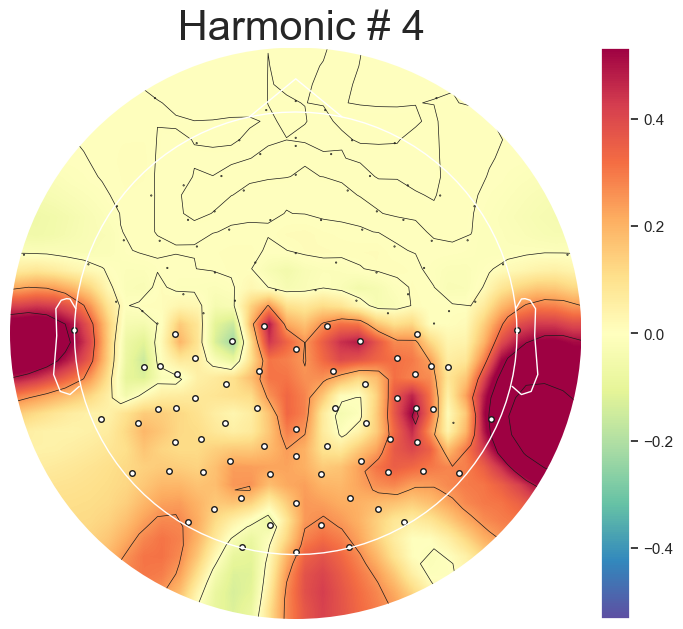

(128,)


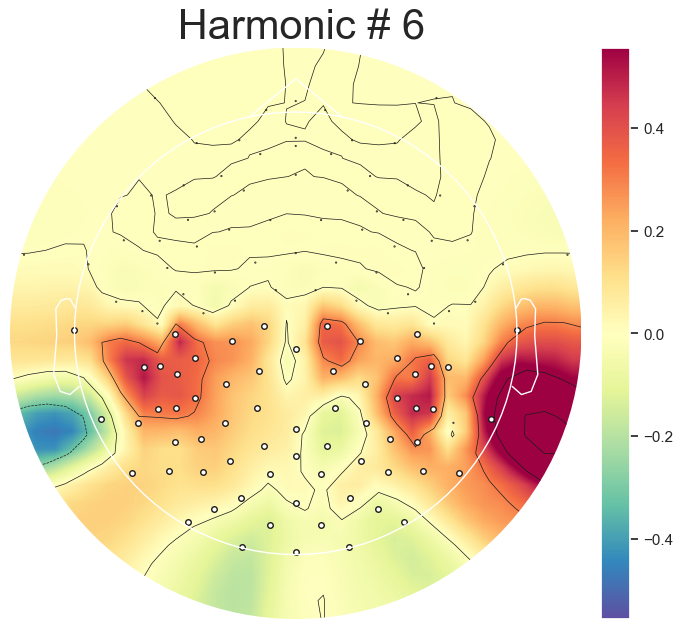

(128,)


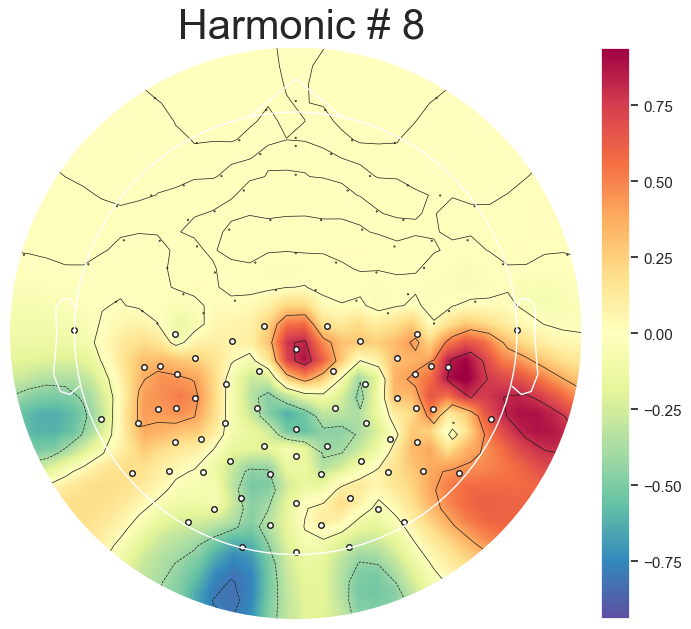

In [54]:
for i in range(NumHarms):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 10),gridspec_kw=dict(height_ratios=[3]))
    axes.set_title(f' Harmonic # {(i+1)*2}', fontsize = 30)
    axes.axis('off')

    dataIn = np.array(bda_f2[0][0][i,:]) # plot data per bin
    print(dataIn.shape)
    # hashtag below to plot all channel activity
    dataIn[~ocm_chans] = 0 # want to index good channels only and set the rest channels to 0 value
    im,_ = plot_topomap(dataIn, info,mask = ocm, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours = 4)
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    plt.show()

In [ ]:
# def DataSort(
    
sIn = 4    
fx = xF1HemiBins[sIn]



fx_sorted = {}
fx_avg = np.zeros((NumBins,int(len(chanList)),2)) # bins x channel x pre/post
fx_diff = np.zeros((NumBins,int(len(chanList))))
fx_sum = np.zeros_like(fx_diff)
fx_diffArith = np.zeros_like(fx_diff)

for harmonic in range(NumHarms):
    nt = int((fx[harmonic].shape[2])/2)
    fx_temp = np.reshape(fx[harmonic], newshape = (NumBins,int(NumChans),2,nt))
    #get pre and post inducrion average
    for induCo in range(2):
        fx_avg[:,:,induCo] = np.nanmean(fx_temp[:,:,induCo,:], axis = 2) # 6 x 128 

    for bin in range(NumBins):
        fx_diff[bin,:] = fx_avg[bin,:,1] - fx_avg[bin,:,0] # post - pre
        fx_sum[bin,:] = fx_avg[bin,:,1] + fx_avg[bin,:,0] 

        fx_diffArith[bin,:] = 2*((fx_diff[bin,:])/(fx_sum[bin,:]))




In [ ]:
fx_diffArith.shape

for bin in range(NumBins):
    plt.scatter(chanList,fx_diffArith[bin,:])
plt.hlines(0, xmin = 0, xmax = 127, color = 'black', linewidth = 5)

In [ ]:
print(f1_sorted[1].shape)

pre_m1 = np.nanmean(f1_sorted[1][:,:,0,:], axis = 2)
post_m1 = np.nanmean(f1_sorted[1][:,:,1,:],axis = 2)

In [ ]:
print(pre_m1.shape)

In [ ]:
prepost_bound= int(NumTrials/2) # reshape will occure at this ind 

xF1_pre_post = {} # F1 pre post data
xF2_pre_post = {} # F2 pre post data

for i in range(Bins):
    xF1_pre_post[i] = np.reshape(xF1Bins[i], newshape = (4,NumChans,prepost_bound,2))
    xF2_pre_post[i] = np.reshape(xF2Bins[i], newshape = (4,NumChans,prepost_bound,2)) # 4 x 128 x pre / post trials  x 2# 

#### visualize data not for analysis - data is not comperable but more to make sure there is variance between trials, hemifields and harmonics

In [ ]:
pickBin = 0
pickTrial = 9
print(f'channel activity per trial: harmonic, bin and hemifield')
ch_list = np.arange(0,NumChans,1)

for i in range(4):
    plt.scatter(ch_list,xF1_pre_post[pickBin][i,:,pickTrial,0], label = f'{(i+1)*2}F1 pre') # plot per channel actiivity 
    plt.legend()
plt.show()
for i in range(4):
    plt.scatter(ch_list,xF1_pre_post[pickBin][i,:,pickTrial,1], label = f'{(i+1)*2}F1 post') # plot per channel actiivity 
    plt.legend()
plt.show()

for i in range(4):
    plt.scatter(ch_list,xF2_pre_post[pickBin][i,:,pickTrial,0], label = f'{(i+1)*2}F2 pre') # plot per channel actiivity 
    plt.legend()
plt.show()
for i in range(4):
    plt.scatter(ch_list,xF2_pre_post[pickBin][i,:,pickTrial,1], label = f'{(i+1)*2}F2 post') # plot per channel actiivity 
    plt.vlines(40, ymin = 0 , ymax = 3, color = 'black')
    plt.vlines(100, ymin = 0, ymax = 3, color = 'black')
    plt.legend()
plt.show()

#### Concate Data Across Bins to Get Average Activity Per Channel, Bin and Harmonic

In [ ]:
xF1_CleanAvgs = {}
xF2_CleanAvgs = {}

for prepost in range(2):
    xF1_CleanAvgs[prepost] = {} # make a new dict key for pre and then post 
    xF2_CleanAvgs[prepost] = {}
    for bin in range(Bins):
        #enter data dict
        xF1_dIn = xF1_pre_post[bin] # 4  x 128 x ntrials x pre / post
        xF2_dIn = xF2_pre_post[bin]
        # avg harmonic activity per channel
        xF1_CleanAvgs[prepost][bin] = np.nanmean(xF1_dIn[:,:,:,prepost],axis = -1) # average data per trial to get 1 val per channel
        xF2_CleanAvgs[prepost][bin] = np.nanmean(xF2_dIn[:,:,:,prepost],axis = -1) # average data per trial to get 1 val per channel

#### Sanity check plot

In [ ]:
pepo = ['pre', 'post']

binInd = 5
fig, axs = plt.subplots(1,2,figsize = (10,5),sharey = True)
for prepost in range(2):
    dIn = xF1_CleanAvgs[prepost]
    for hi in range(4):
        axs[prepost].scatter(ch_list,dIn[binInd][hi,:], label = f'{(hi+1)*2}F1 {pepo[prepost]}')
        axs[prepost].hlines(0,xmin = 0,xmax = 128, color = 'black')
    plt.suptitle('XF1 average channel activity per bin')
    axs[prepost].legend()

fig, axs = plt.subplots(1,2,figsize = (10,5),sharey = True)
for prepost in range(2):
    dIn = xF2_CleanAvgs[prepost]
    for hi in range(4):
        axs[prepost].scatter(ch_list,dIn[binInd][hi,:], label = f'{(hi+1)*2}F2 {pepo[prepost]}')
        axs[prepost].hlines(0,xmin = 0,xmax = 128, color = 'black')
    plt.suptitle('XF2 average channel activity per bin')
    axs[prepost].legend()


#### Combine Data Across Harmonics 

In [ ]:
XF1_Data = {}
XF2_Data = {}

for prepost in range(2):
    
    XF1_Data[prepost] = {}
    XF2_Data[prepost] = {}
    temp_XF1 = np.concatenate([xF1_CleanAvgs[prepost][x] for x in xF1_CleanAvgs[prepost]])
    temp_XF2 = np.concatenate([xF2_CleanAvgs[prepost][x] for x in xF2_CleanAvgs[prepost]])
    XF1_Data[prepost] = np.reshape(temp_XF1, newshape = (4,Bins,NumChans))
    XF2_Data[prepost] = np.reshape(temp_XF2, newshape =(4,Bins,NumChans))

In [ ]:
fig,axs = plt.subplots(1,2, figsize = (12,6), sharey = True)
plt.suptitle('Pre  + Post Channel Activity XF2')
for pltpos in range(2):
    pepo = XF2_Data[pltpos] # plot pre and post data
    for i in range(Bins):
        harmtwo  = pepo[0,i,:]
        ht = np.nanmean(harmtwo,axis = 0) # 128 points of avg channel activity pre or post 
        axs[pltpos].scatter(ch_list,harmtwo, label = f'Bin: {i}')
        axs[pltpos].legend()
# plt.title(f'activity per channel across all bins')

# Compute Difference in Response Activity Post - Pre Induction
## Method # 1: Post - Pre

### XF1 Data  

In [ ]:
f1_temp_pre = XF1_Data[0] # 4 x 6 x 128
f1_temp_post = XF1_Data[1] # 4 x 6 x 128

XF1_diffs = np.zeros_like((f1_temp_pre)) # temporary store of data 

for hi in range(4):
    for bin in range(Bins):
        diff = (f1_temp_post[hi,bin,:] - f1_temp_pre[hi,bin,:])
        XF1_diffs[hi,bin,:] = diff

### XF2 Data

In [ ]:
f2_temp_pre = XF2_Data[0] # 4 x 6 x 128
f2_temp_post = XF2_Data[1] # 4 x 6 x 128

XF2_diffs = np.zeros_like((f2_temp_pre)) # temporary store of data 

for hi in range(4):
    for bin in range(Bins):
        diff = (f2_temp_post[hi,bin,:] - f2_temp_pre[hi,bin,:])
        XF2_diffs[hi,bin,:] = diff

## **Checkpoint #2** Before Plotting Topos

In [ ]:
if np.sum(XF1_diffs == XF2_diffs) == 0:
    print(f'Data does not overlap, good sign') # check if data is the same
else:
    print(f'check data indcies as data is the same for both hemifields')

### Select Harmonic Data to Visualize, transpose data and Add Dead Channel for Montage

In [ ]:
Harmonic = 0 # pick harmoic data to plot on topo

### XF1 Difference Data 

In [ ]:
F1_Diffs = XF1_diffs[Harmonic,:,:].T  # 128 x 6 - 0 -== 2f
print(F1_Diffs.shape)

### XF2 Difference Data 

In [ ]:
F2_Diffs = XF2_diffs[Harmonic,:,:].T  # 128 x 6 - 0 -== 2f
print(F2_Diffs.shape)

# Select EEG Montage for MNE

## Import and Set EEG Sensor Location File and Set as Default Montage

In [ ]:
# eegMontageDir = 'C:\\plimon\\LTP_analysis\\eegSensorLocs\\9_18AverageNet128_v1.sfp'#AdultAverageNet128_v1.sfp'
# # Check if the file exists
# if os.path.exists(eegMontageDir):
#     # Load the electrode locations file
#     montageIn = mne.channels.read_custom_montage(eegMontageDir) # import file
#     print("Electrode locations loaded successfully.")
# else:
#     print("The specified file does not exist.")
# print(montageIn)
# #### Get channel names to use
# info = mne.create_info(ch_names=montageIn.ch_names, sfreq=1, ch_types="eeg")
# info.set_montage(montageIn)

In [18]:
montageIn = mne.channels.make_standard_montage("GSN-HydroCel-128")
info = mne.create_info(ch_names=montageIn.ch_names, sfreq=1, ch_types="eeg")
info.set_montage(montageIn)
print(montageIn)

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 128 channels>


## Visualize Data

In [ ]:
p = XF1_Data[0]
data = p[Harmonic,:,:].T  # 128 x 6 - 0 -== 2f

for i in range(Bins):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 10),gridspec_kw=dict(height_ratios=[3]))
    axes.set_title(f' Pre F1 Bin # {i+1}', fontsize = 30)
    axes.axis('off')

    dataIn = data[:,i] # plot data per bin
    # hashtag below to plot all channel activity
    dataIn[~ocm] = 0 # want to index good channels only and set the rest channels to 0 value
    im,_ = plot_topomap(dataIn, info,mask = ocm, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours = 4)
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    plt.show()

In [ ]:
p = XF1_Data[1]
data = p[Harmonic,:,:].T  # 128 x 6 - 0 -== 2f


for i in range(Bins):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 12),gridspec_kw=dict(height_ratios=[3]))
    axes.set_title(f'Post F1 Bin # {i+1}', fontsize = 30)
    axes.axis('off')

    dataIn = data[:,i]
    dataIn[~ocm] = 0 # want to index good channels only and set the rest channels to 0 value
    im,_ = plot_topomap(dataIn, info,mask = ocm, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours = 3)
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    plt.show()

#### Plot F1 Difference post induction

In [ ]:
for i in range(Bins):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 12),gridspec_kw=dict(height_ratios=[3]))
    axes.set_title(f'F1 response change post induction, Bin # {i+1}', fontsize = 30)
    axes.axis('off')

    dataIn = F1_Diffs[:,i]
    dataIn[~ocm] = 0 # want to index good channels only and set the rest channels to 0 value
    im,_ = plot_topomap(dataIn, info,mask = ocm, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours = 3)
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    plt.show()

##### Ploting F2 Data Now, 2nd harmonic

In [ ]:
p = XF2_Data[0]

data = p[0,:,:].T  # 128 x 6 - 0 -== 2f

for i in range(Bins):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 12),gridspec_kw=dict(height_ratios=[3]))
    axes.set_title(f'Pre F2 Bin # {i+1}', fontsize = 30)
    axes.axis('off')

    dataIn = data[:,i] # 129 array
    dataIn[~ocm] = 0 # want to index good channels only and set the rest channels to 0 value
    im,_ = plot_topomap(dataIn, info,mask = ocm, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours = 3)
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    plt.show()

In [ ]:
p = XF2_Data[1]
data = p[0,:,:].T  # 128 x 6 - 0 -== 2f

for i in range(Bins):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 12),gridspec_kw=dict(height_ratios=[3]))
    axes.set_title(f'Post F2 Bin # {i+1}', fontsize = 30)
    axes.axis('off')

    dataIn = data[:,i]
    dataIn[~ocm] = 0 # want to index good channels only and set the rest channels to 0 value
    im,_ = plot_topomap(dataIn, info,mask = ocm, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours = 4)
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    plt.show()

In [ ]:
for i in range(Bins):
    #plt.plot(topodata[:,i])
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 12),gridspec_kw=dict(height_ratios=[3]))
    axes.set_title(f'F2 response change post induction, Bin # {i+1}', fontsize = 30)
    #placeholder = np.random.random((10, 10))
    #axs.imshow(placeholder)
    axes.axis('off')

    dataIn = F2_Diffs[:,i]
    dataIn[~ocm] = 0 # want to index good channels only and set the rest channels to 0 value
    im,_ = plot_topomap(dataIn, info,mask = ocm, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours = 3)
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    plt.show()

In [ ]:
# topodata = p[0,:,:].T
# print(topodata.shape)
# emptyChData = np.zeros((1,6))
# print(emptyChData.shape)

# dataFull = np.array(np.concatenate((topodata,emptyChData)))

# data = dataFull[:,4]

# # create array with 4 points for our 4 channels
# # in the same order as provided in ch_names
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10),gridspec_kw=dict(height_ratios=[3]))
# axes.set_title(f'subj topo plot', fontsize = 30)
# # placeholder = np.random.random((10, 10))
# # axes.imshow(placeholder)
# axes.axis('off')

# #info = create_info(ch_names=montageIn._names, sfreq=1, ch_types='eeg')
# # channel names I provided are part of a standard montage
# #info.set_montage(montageIn) # import file)
# im,_ = plot_topomap(data, info, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours = 8)
# divider = make_axes_locatable(axes)
# cax = divider.append_axes('right', size='5%', pad=0.2)
# cbar = plt.colorbar(im, cax=cax)
# plt.show()

### Good confined example of what data formate is supposed to look like for mne plotting success

In [ ]:
# from mne import create_info
# from mne.viz import plot_topomap
# import numpy as np

# # create array with 4 points for our 4 channels
# # in the same order as provided in ch_names
# data = np.random.randn(4)  
# info = create_info(ch_names=['CPz', 'Oz', 'POz', 'Fz'], sfreq=1000, ch_types='eeg')
# # channel names I provided are part of a standard montage
# info.set_montage('standard_1020')

# plot_topomap(data, info)

In [ ]:
# topodata = p[0,:,:].T  # 128 x 6 - 0 -== 2f
# #have to add some fck channel data because egi file included one extra channel
# emptyChData = np.zeros((1,6)) # 1 x 6
# data = np.array(np.concatenate((topodata,emptyChData))) # 129 x 6 


# for i in range(6):
#     #plt.plot(topodata[:,i])
#     fig, axs = plt.subplots(figsize = (6,6))
#     axs.set_title(f'Bin # {i}')
#     axs.legend()
#     print(i)
#     dataIn = data[:,i]
#     mne.viz.plot_topomap(dataIn, info, axes = axs)

#### plot formats of the past and present(?)

In [ ]:
# fig = plt.figure(figsize = (10,10))
# ax = fig.add_subplot(111, projection='3d')
# montageIn.plot(kind='3d', axes=ax)
# ax.set_title('Sensor Locations')
# plt.show()
# # Plot the sensors on a 2D head model
# fig, ax = plt.subplots()
# montageIn.plot(kind='topomap', show_names=True, axes=ax)
# ax.set_title('Sensor Locations (2D)')
# plt.show()

In [ ]:
# #montge default info in case egi outut file fails me 
# montage_type = mne.channels.make_standard_montage("GSN-HydroCel-128")
# print(montage_type)

In [ ]:
# h_label = ['2F','4F','6F','8F']

# fig,axs = plt.subplots(6,1, figsize = (10,40))
# for i in range(6):
#     dIn = axs[i].imshow(XF1_Data[0][:,i,ExportChans],aspect='auto', cmap=sns.cubehelix_palette(as_cmap=True))
#     axs[i].set_xticks(np.arange(len(ExportChans)))
#     axs[i].set_xticklabels(ExportChans,rotation=45)
#     axs[i].set_yticks(np.arange(len(h_label)))  # Set y-ticks to match the length of y_labels
#     axs[i].set_yticklabels(h_label) 
#     axs[i].set_title('Pre F1 Data')
#     axs[i].set_xlabel('Channels')
#     axs[i].set_ylabel('Amplitude')
#plt.show()
# fig,axs = plt.subplots(6,1, figsize = (10,40))
# for i in range(6):
#     dIn = axs[i].imshow(XF1_Data[1][:,i,ExportChans],aspect='auto', cmap=sns.cubehelix_palette(as_cmap=True))
#     axs[i].set_xticks(np.arange(len(ExportChans)))
#     axs[i].set_xticklabels(ExportChans,rotation=45)
#     axs[i].set_yticks(np.arange(len(h_label)))  # Set y-ticks to match the length of y_labels
#     axs[i].set_yticklabels(h_label) 
#     axs[i].set_title('Post F1 Data')
#     axs[i].set_xlabel('Channels')
#     axs[i].set_ylabel('Amplitude')
# fig,axs = plt.subplots(6,1, figsize = (10,40))
# for i in range(6):
#     dIn = axs[i].imshow(XF2_Data[0][:,i,ExportChans],aspect='auto', cmap=sns.cubehelix_palette(as_cmap=True))
#     axs[i].set_xticks(np.arange(len(ExportChans)))
#     axs[i].set_xticklabels(ExportChans,rotation=45)
#     axs[i].set_yticks(np.arange(len(h_label)))  # Set y-ticks to match the length of y_labels
#     axs[i].set_yticklabels(h_label) 
#     axs[i].set_title('Pre F2 Data')
#     axs[i].set_xlabel('Channels')
#     axs[i].set_ylabel('Amplitude')
# fig,axs = plt.subplots(6,1, figsize = (10,40))
# for i in range(6):
#     dIn = axs[i].imshow(XF2_Data[1][:,i,ExportChans],aspect='auto', cmap=sns.cubehelix_palette(as_cmap=True))
#     axs[i].set_xticks(np.arange(len(ExportChans)))
#     axs[i].set_xticklabels(ExportChans,rotation=45)
#     axs[i].set_yticks(np.arange(len(h_label)))  # Set y-ticks to match the length of y_labels
#     axs[i].set_yticklabels(h_label) 
#     axs[i].set_title('Post F2 Data')
#     axs[i].set_xlabel('Channels')
#     axs[i].set_ylabel('Amplitude')